# Evaluating Model Performance

In this notebook (finished 6th September 2023) I am going to explore the current state of models priduced using PICTS_ML and the events catalogue. Author: Dave Riley

## Summary

#### "V1"
Initially models were retrained using PICTS training data where the P & S wave arrivals had been picked in an automated fashion using a travel time model (TauPy):
* 1108 total traces made up the dataset (low effort / nearly instant to produce)
* The retrained models had significantly increased false positives versus readily available pretrained models
* The retrained models became slightly better at detecting some earthquakes, but worse at detecting others

#### "V2"
It was noted that a number of the automated picks made using the travel time model appeared to be wrong. Manual picking was employed (the first time I had tried this), using the TauPy model as guidence, to create PICTS training data. A basic analysis was conducted by randomly picking streams from PICTS and annotating them using a retrained model (trained on the PICTS data) and pretrained models:
* 34 total traces made up the dataset (med-high effort / time to produce)
* The retrained models had a false positive rate lower than "V1"; it was closer to readily available pretrained models
* The retrained models showed promise by ocassionally detecting waves of potential interest that were missed by the readily available pretrained models
* The retrained models missed some waves of interest that the readily available pretrained models did not

#### "V3"
I had the opportunity to get an fairly in-depth lesson on manual picking from Amy, and realised that I had got a lot of "V2" picks wrong. I also realised just how differently the waveforms from earthquakes could look. Previously I had mistaken later waves for P & S wave arrivals due to the later waves looking very simliar to P & S wave arrivals presented in textbooks, and the actual P & S wave arrivals looking very different (to me at any rate). This notebook presents a slightly more rigorous analysis of the "V3" models trained on this data:
* 71 total traces make up the dataset (high effort / time to produce)
* The retrained models often have a false positive rate similar to that of the readily available pretrained models
* The retrained models appear to often 'miss' the picks by ~60s

## Working Conclusions

* Manual picking has been slow and I'm not confient that even in "V3" that is has been accurate
* It is possible that the very different appearances of the P & S waves arriving, combined with the nature of model training in general, mean that much bigger datasets need to be used to retrain models before firmer conclusions are made
* Some form of hybrid manual - travel time - ML picker approach may be able to produce training data with more speed, less effort and/or more accuracy

Please see our presentation poster for further conclusions regarding the project and our use of ML picking on it.


## Setting up

In [73]:
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import obspy
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch

import picts_ml.shared_data_files.shared_functions as functions

Load the models to evaluate:

In [140]:
retrained_phasenet_stead = sbm.PhaseNet().load("trained_models/phasenet_stead_retrained_picts", version_str="1")
with open("trained_models/phasenet_stead_retrained_picts.info.v1") as file:
    print(file.read())
retrained_phasenet_instance = sbm.PhaseNet().load("trained_models/phasenet_instance_retrained_picts", version_str="1")

Date created: 2023-09-04 20:31:12.344193
Name: phasenet_stead_retrained_picts
Model type: phasenet 'stead'
Training data name: 01_pre_process_data_outputs/preprocessed_event_data_2023-08-27 14:41:24.838809.csv
Training data size: 71

Epochs: 100
Sigma: 30
Learning rate: 0.01



In [142]:
retrained_phasenet_ethz = sbm.PhaseNet().load("trained_models/phasenet_ethz_retrained_picts", version_str="1")
with open("trained_models/phasenet_ethz_retrained_picts.info.v1") as file:
    print(file.read())

Date created: 2023-09-04 20:35:02.820539
Name: phasenet_ethz_retrained_picts
Model type: phasenet 'ethz'
Training data name: 01_pre_process_data_outputs/preprocessed_event_data_2023-08-27 14:41:24.838809.csv
Training data size: 71

Epochs: 100
Sigma: 30
Learning rate: 0.01



In [143]:
retrained_phasenet_instance = sbm.PhaseNet().load("trained_models/phasenet_instance_retrained_picts", version_str="1")
with open("trained_models/phasenet_instance_retrained_picts.info.v1") as file:
    print(file.read())

Date created: 2023-09-04 20:37:39.869238
Name: phasenet_instance_retrained_picts
Model type: phasenet 'instance'
Training data name: 01_pre_process_data_outputs/preprocessed_event_data_2023-08-27 14:41:24.838809.csv
Training data size: 71

Epochs: 100
Sigma: 30
Learning rate: 0.01



In [144]:
ref_model = sbm.PhaseNet.from_pretrained("original")

Load the test data. Note that it is important to ensure that none of the models have been trained using the test data, so we will use the 'test' part of the split from the training data that all of the retrained models have been trained on.

The overall data set is still quite small; I found picking arrivals to be quite challenging.

In [147]:
csv_data = pd.read_csv("events_catalogue/preprocessed_event_data_2023-08-27 14:41:24.838809.csv", header=[0])

In [148]:
trg_data = sbd.WaveformDataset("02_generate_training_data_outputs/", sampling_rate=100, missing_componens="pad")

In [149]:
train, dev, test = trg_data.train_dev_test()
print(f"Overall size: {len(trg_data)}")
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

Overall size: 71
Train: 47
Dev: 11
Test: 13


Create dictionaries of data for arrivals in the test split:

In [81]:
p_arrivals = dict()
s_arrivals = dict()
for index in test.metadata.index:
    trace_start_time = obspy.UTCDateTime(test.metadata.loc[index, "trace_start_time"])
    sample_rate = int(test.metadata.loc[index, "trace_sampling_rate_hz"])
    p_arr_sample = int(test.metadata.loc[index, "trace_p_arrival_sample"])
    p_arr_time = trace_start_time + (p_arr_sample / sample_rate)
    s_arr_sample = int(test.metadata.loc[index, "trace_s_arrival_sample"])
    s_arr_time = trace_start_time + (s_arr_sample / sample_rate)
    network = test.metadata.loc[index, "station_network_code"]
    station = test.metadata.loc[index, "station_code"]
    p_arrivals[(network, station)] = p_arr_time
    s_arrivals[(network, station)] = s_arr_time

## Evaluating models

### Evaluating retrained PhaseNet Instance






**********
Model: retrained_phasenet_instance
 P waves arrival time: 2022-05-08T12:13:01.400000Z
S waves arrival time: 2022-05-08T12:13:01.850000Z
Streams from: 9J G3GB


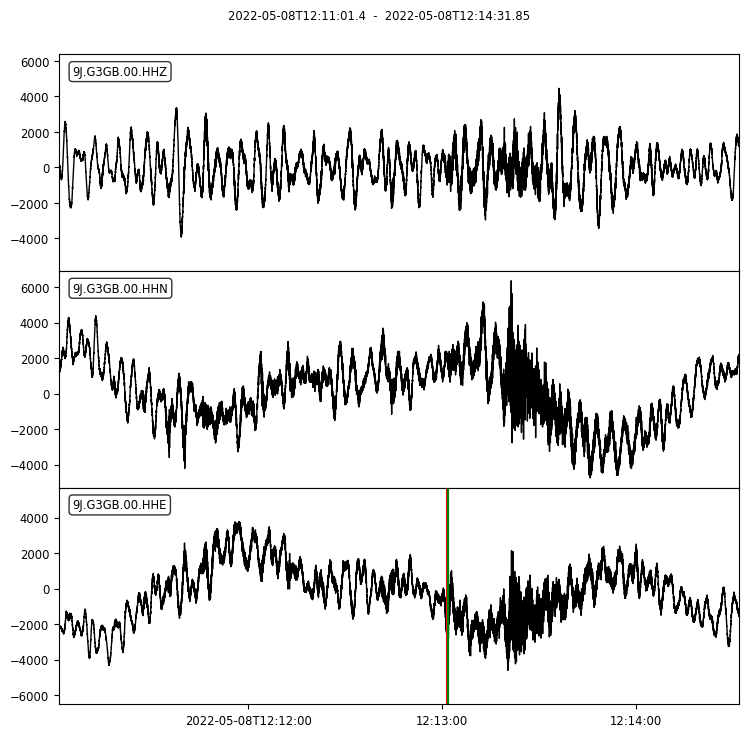

retrained model retrained_phasenet_instance:


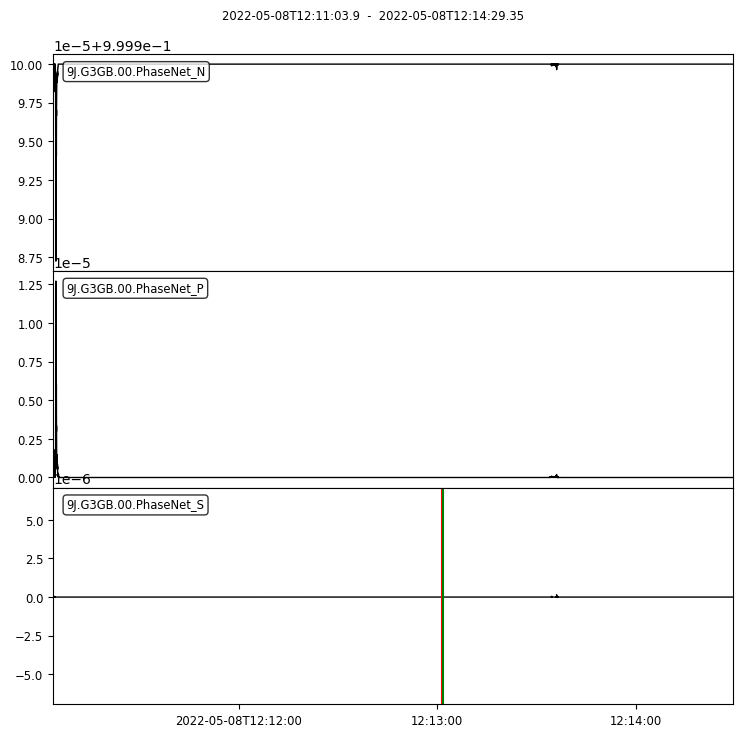

reference model:


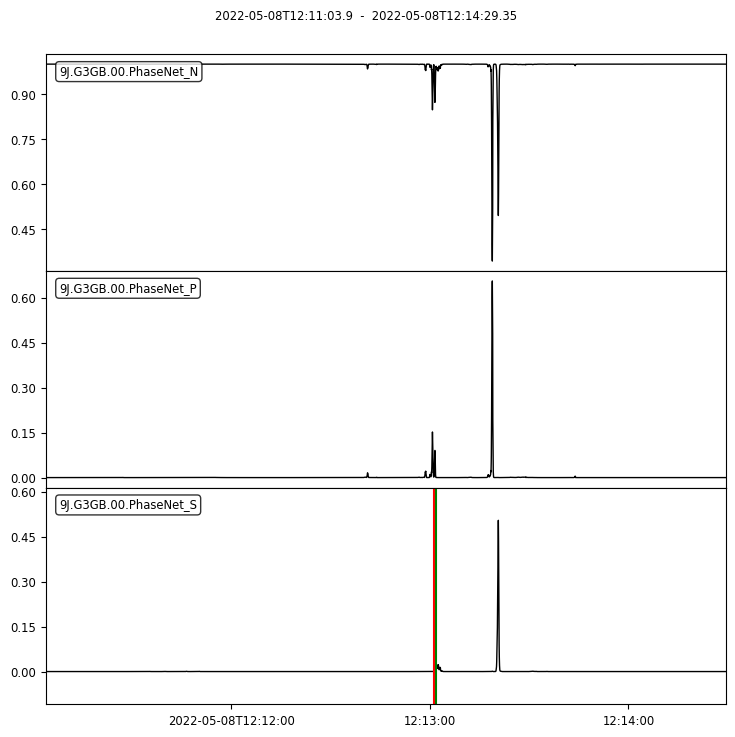

 P waves arrival time: 2022-05-08T12:12:59.610000Z
S waves arrival time: 2022-05-08T12:12:59.810000Z
Streams from: 9J P3MM


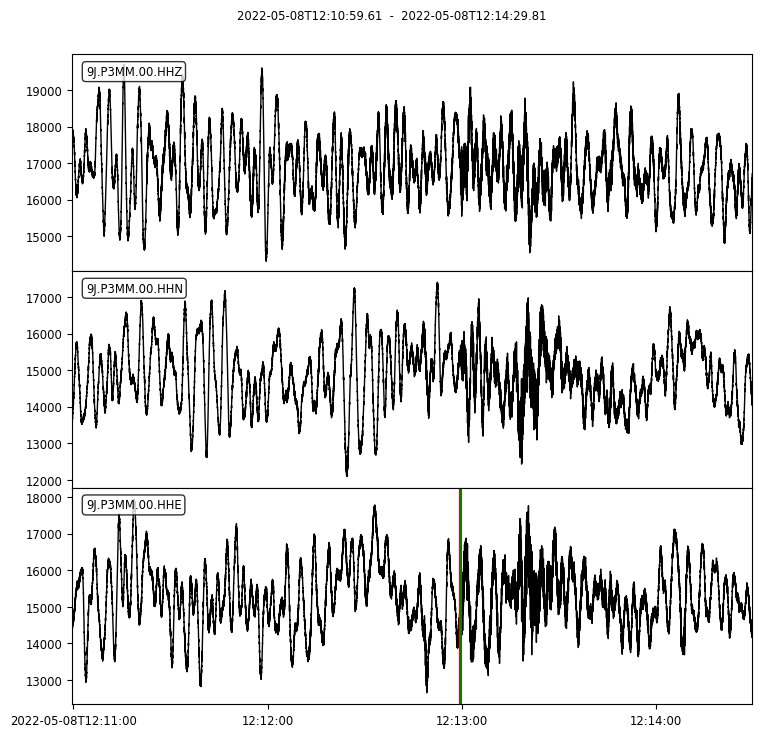

retrained model retrained_phasenet_instance:


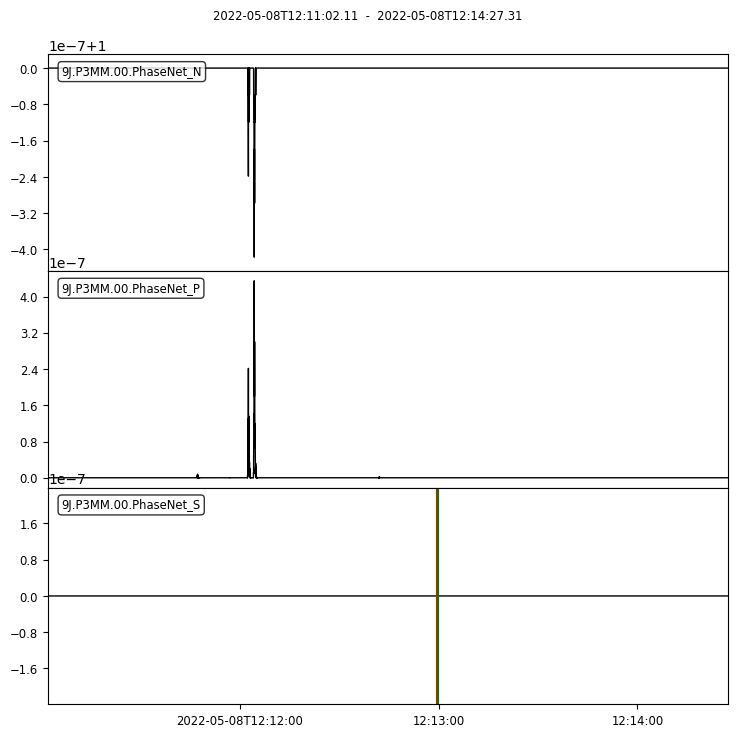

reference model:


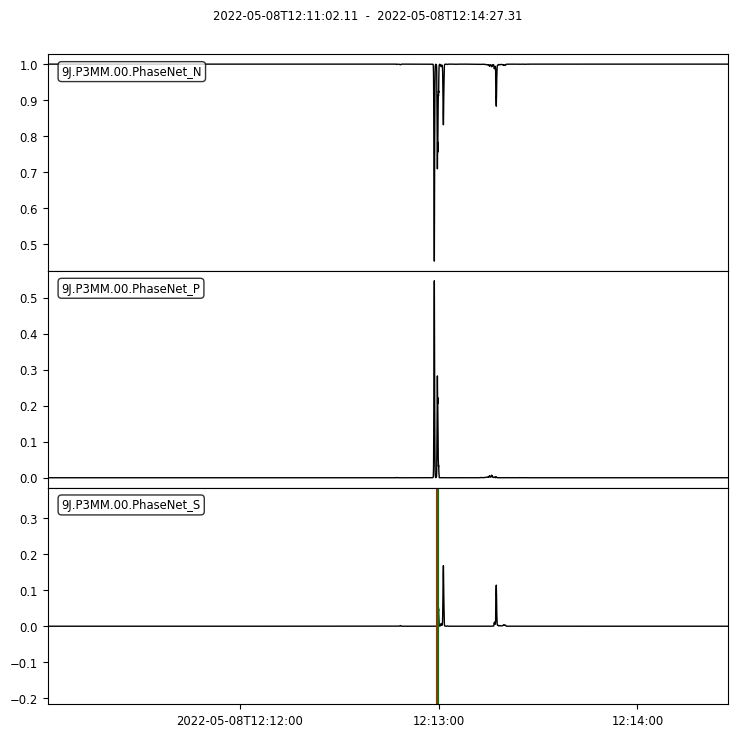

 P waves arrival time: 2022-05-08T12:13:02.380000Z
S waves arrival time: 2022-05-08T12:13:02.740000Z
Streams from: 9J P1GW


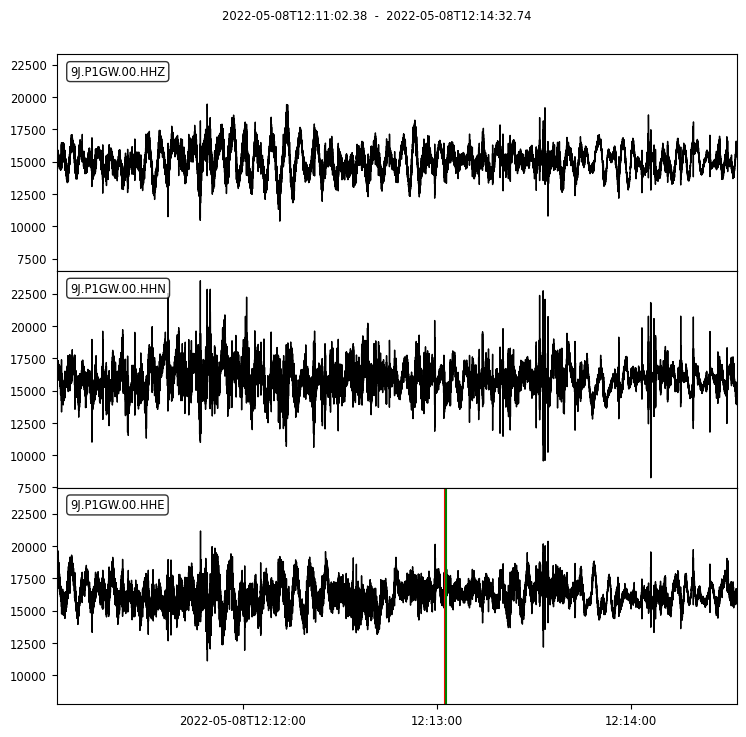

retrained model retrained_phasenet_instance:


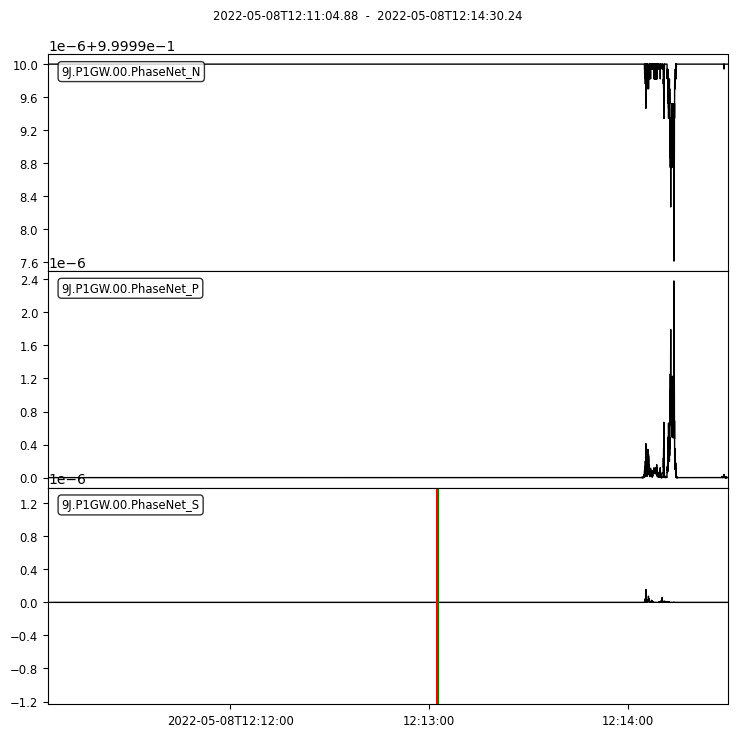

reference model:


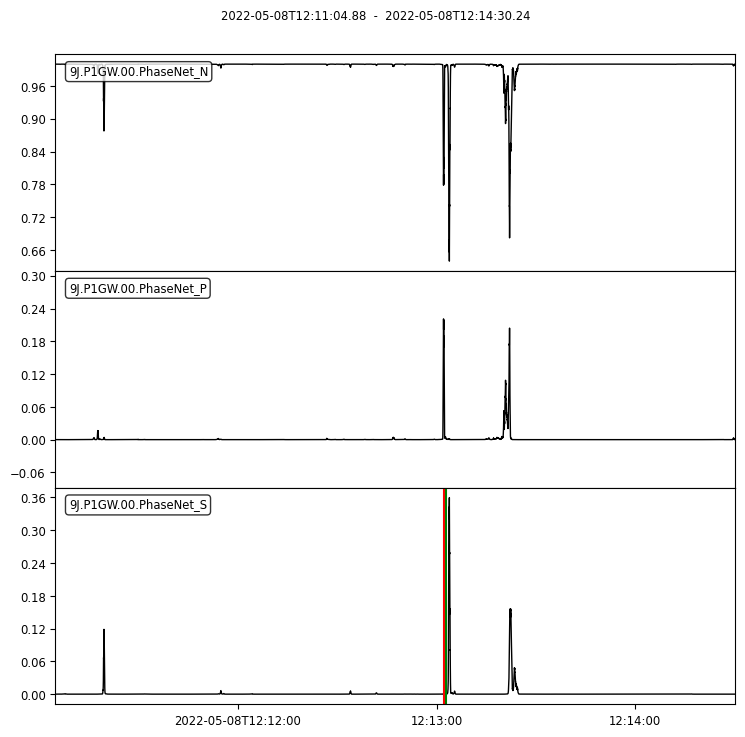

 P waves arrival time: 2022-04-24T09:48:25.720000Z
S waves arrival time: 2022-04-24T09:48:25.840000Z
Streams from: 9J B3FZ


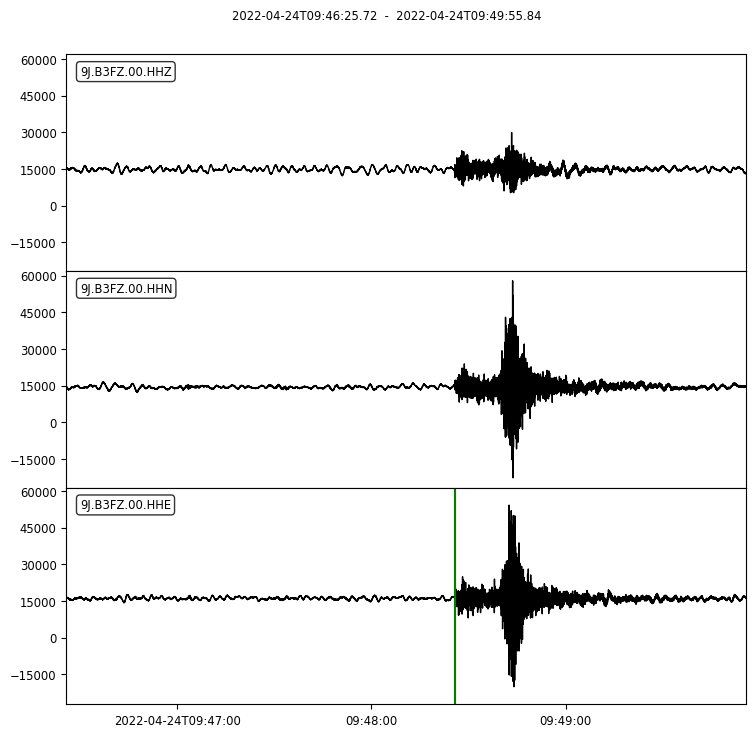

retrained model retrained_phasenet_instance:


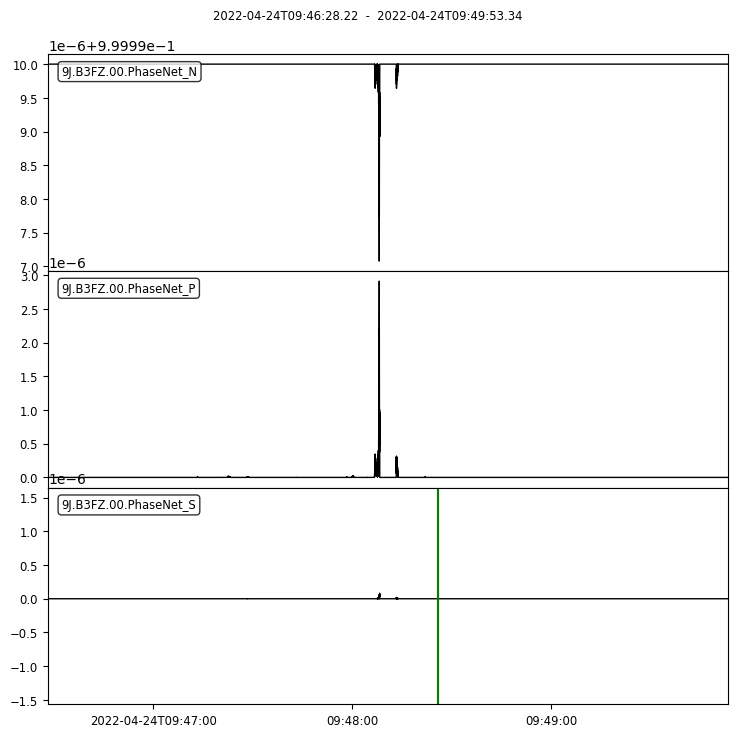

reference model:


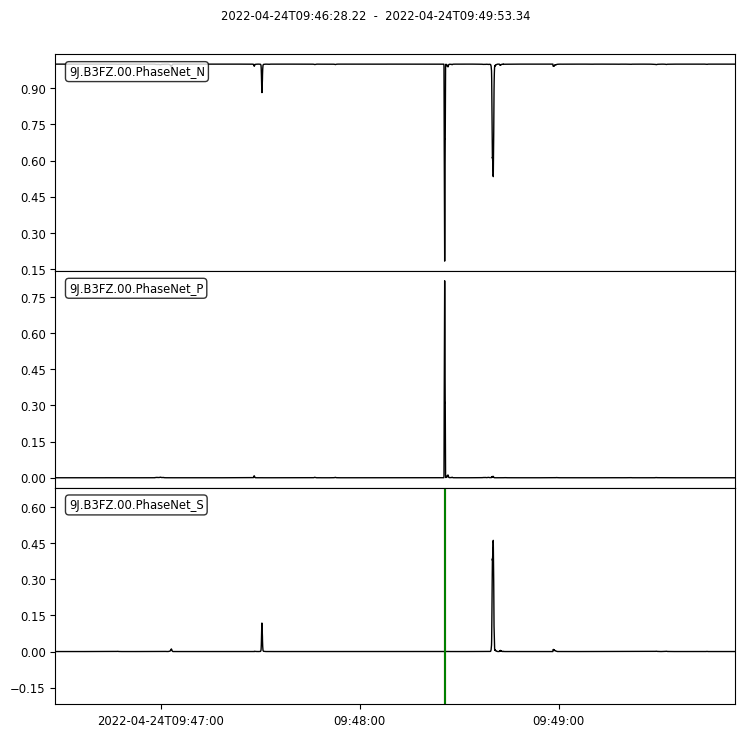

 P waves arrival time: 2022-04-21T04:15:10.000000Z
S waves arrival time: 2022-04-21T04:15:10.460000Z
Streams from: 9J G2EB


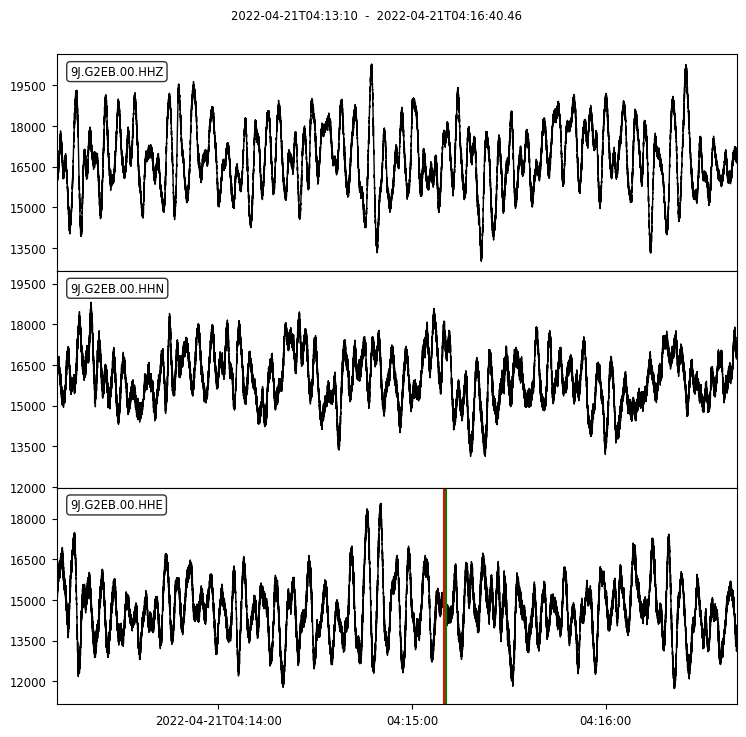

retrained model retrained_phasenet_instance:


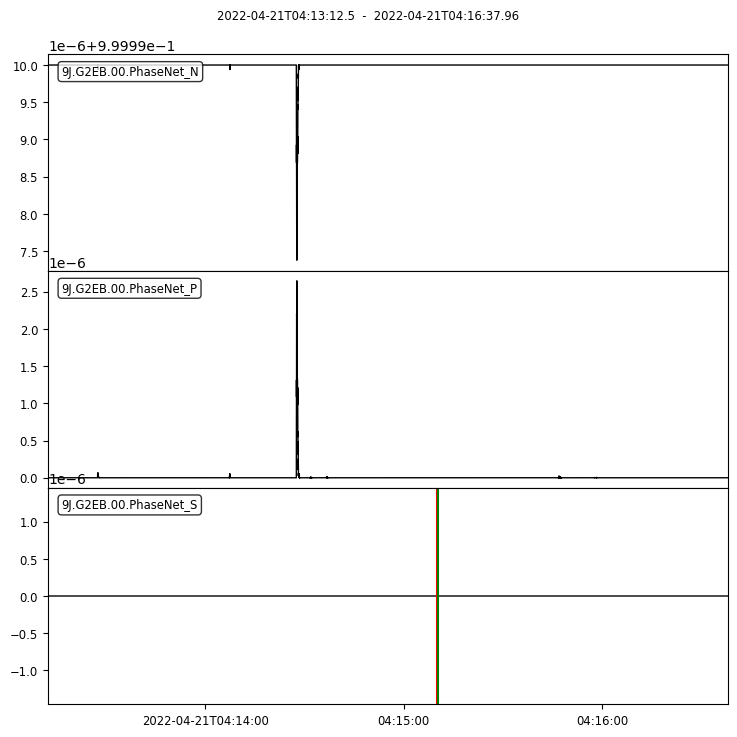

reference model:


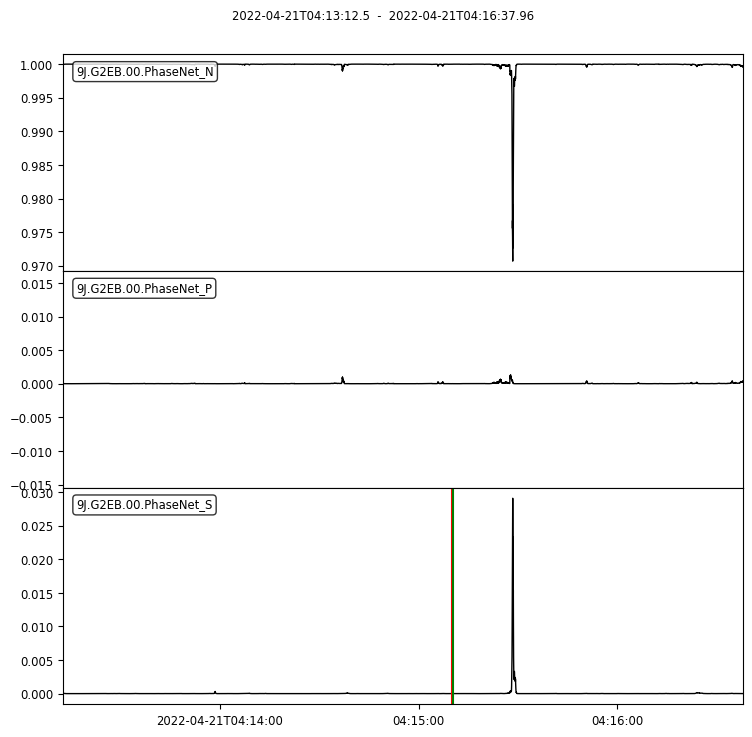

 P waves arrival time: 2022-05-08T12:13:02.060000Z
S waves arrival time: 2022-05-08T12:13:02.380000Z
Streams from: GB TARL


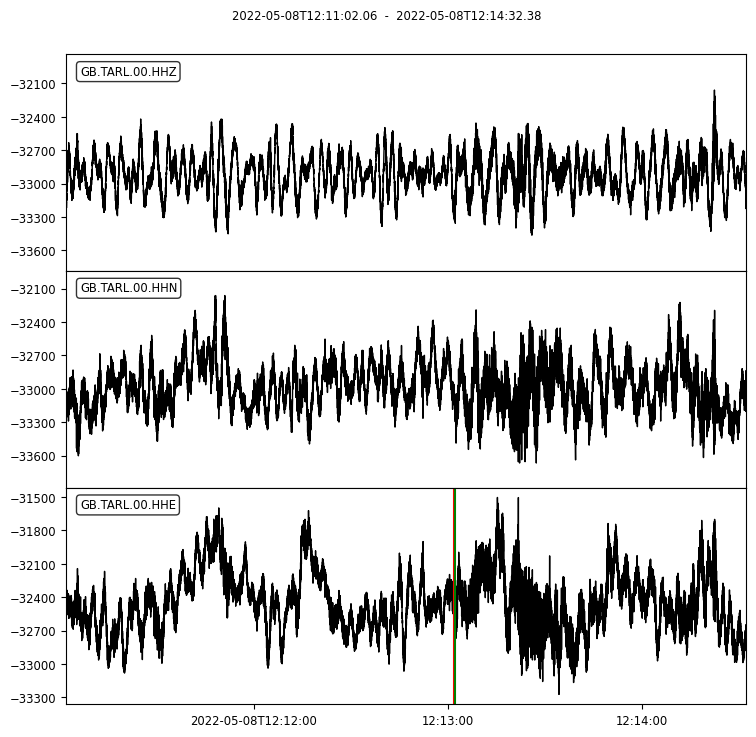

retrained model retrained_phasenet_instance:


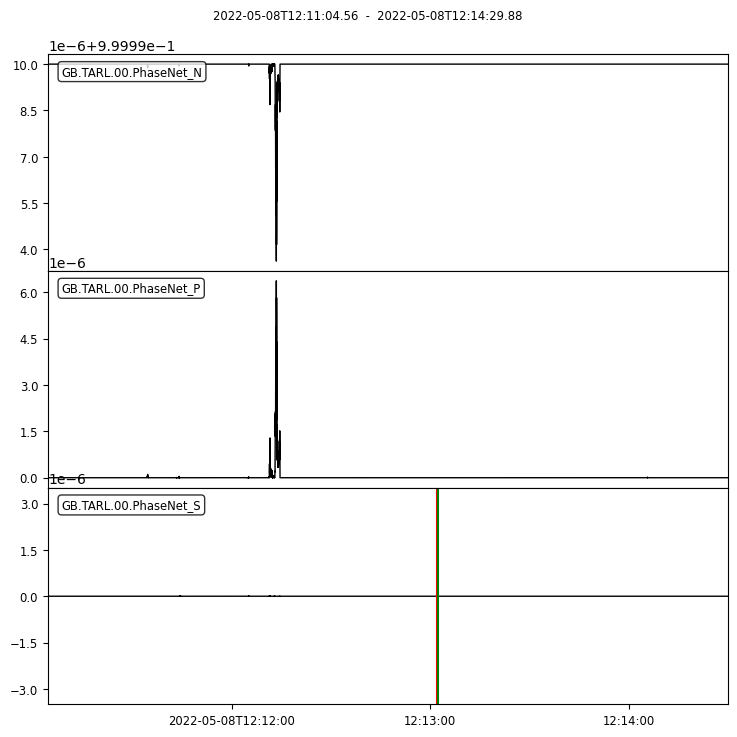

reference model:


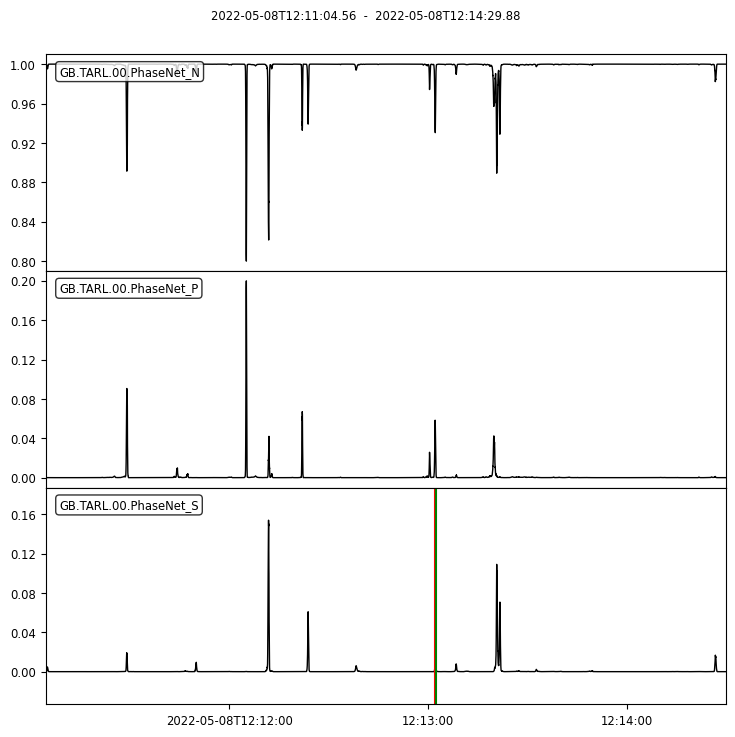




**********
Model: retrained_phasenet_ethz
 P waves arrival time: 2022-05-08T12:13:01.400000Z
S waves arrival time: 2022-05-08T12:13:01.850000Z
Streams from: 9J G3GB


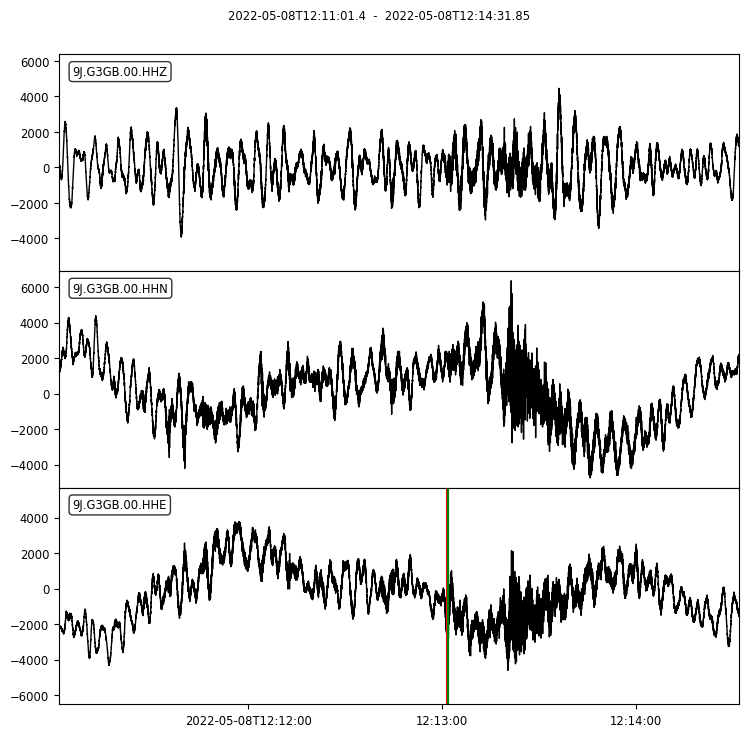

retrained model retrained_phasenet_ethz:


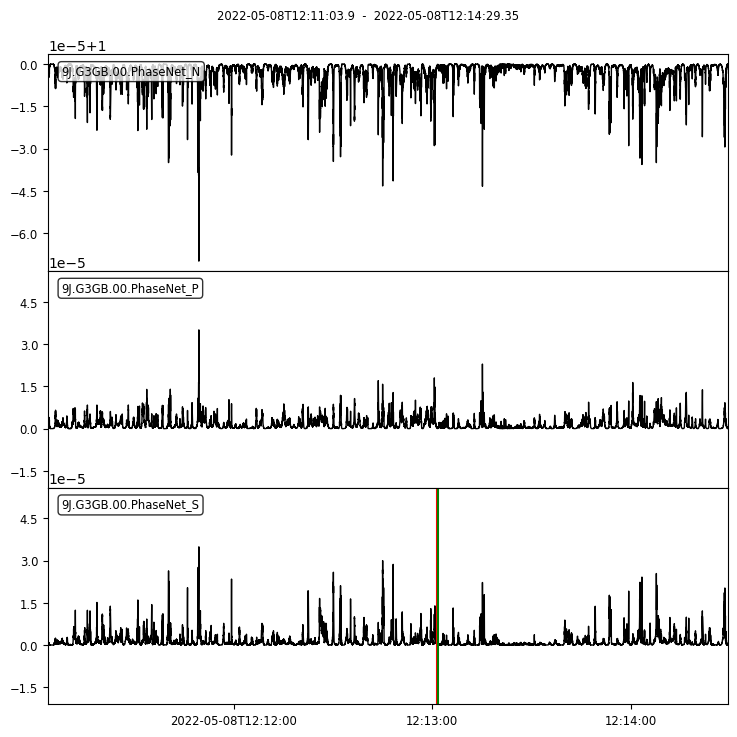

reference model:


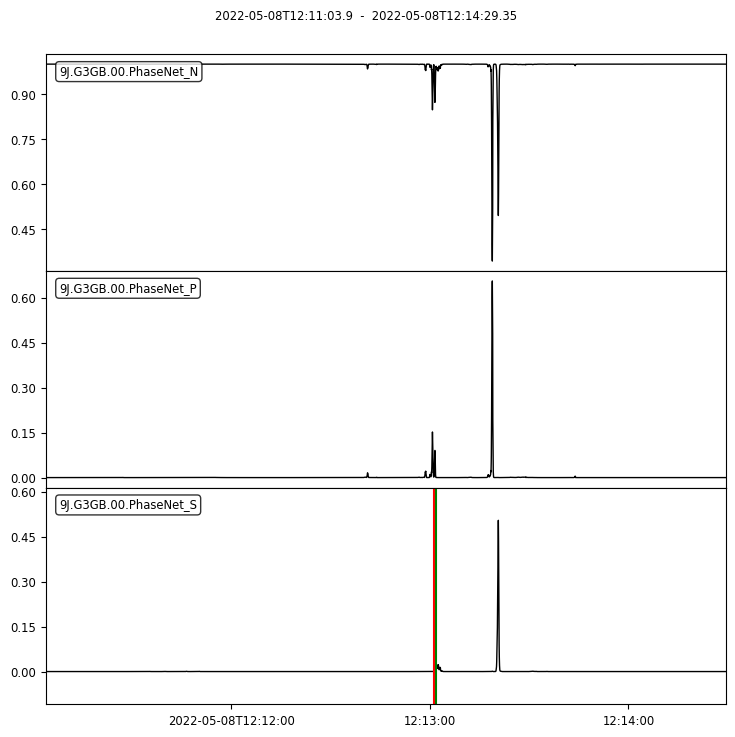

 P waves arrival time: 2022-05-08T12:12:59.610000Z
S waves arrival time: 2022-05-08T12:12:59.810000Z
Streams from: 9J P3MM


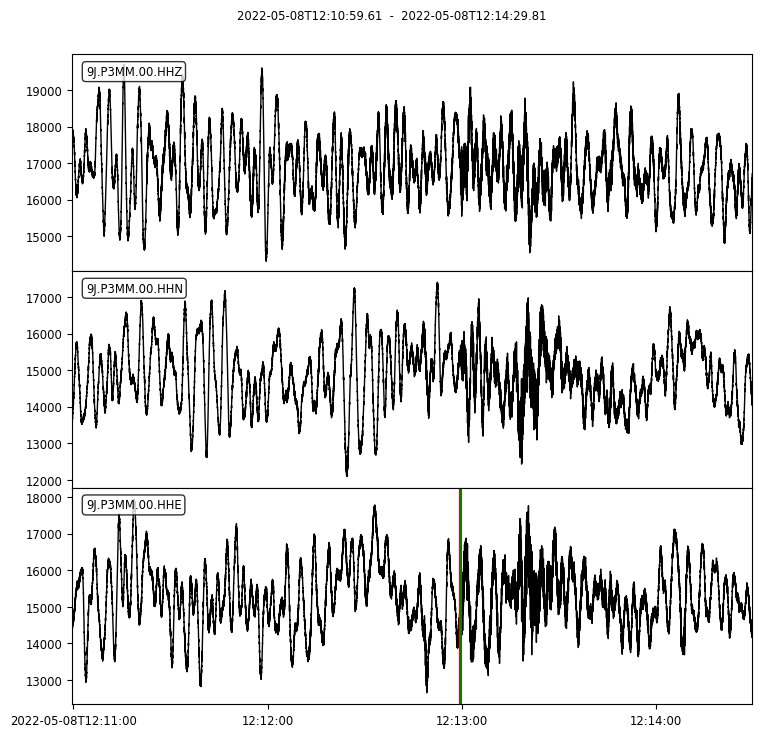

retrained model retrained_phasenet_ethz:


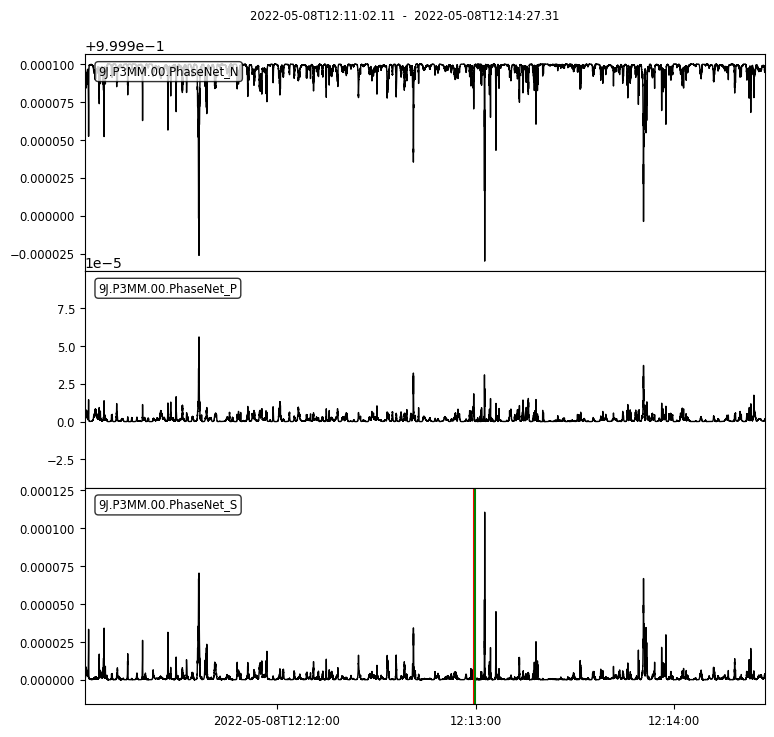

reference model:


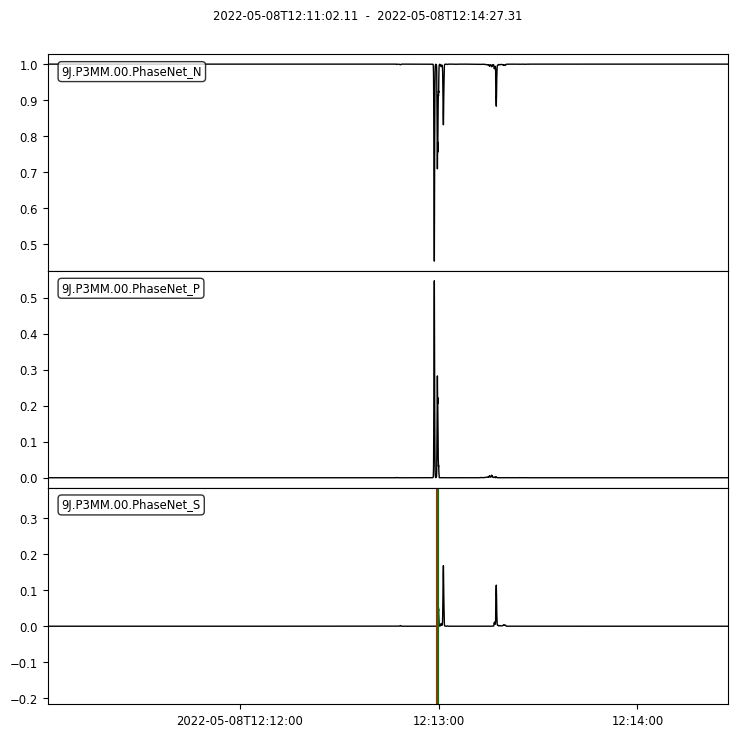

 P waves arrival time: 2022-05-08T12:13:02.380000Z
S waves arrival time: 2022-05-08T12:13:02.740000Z
Streams from: 9J P1GW


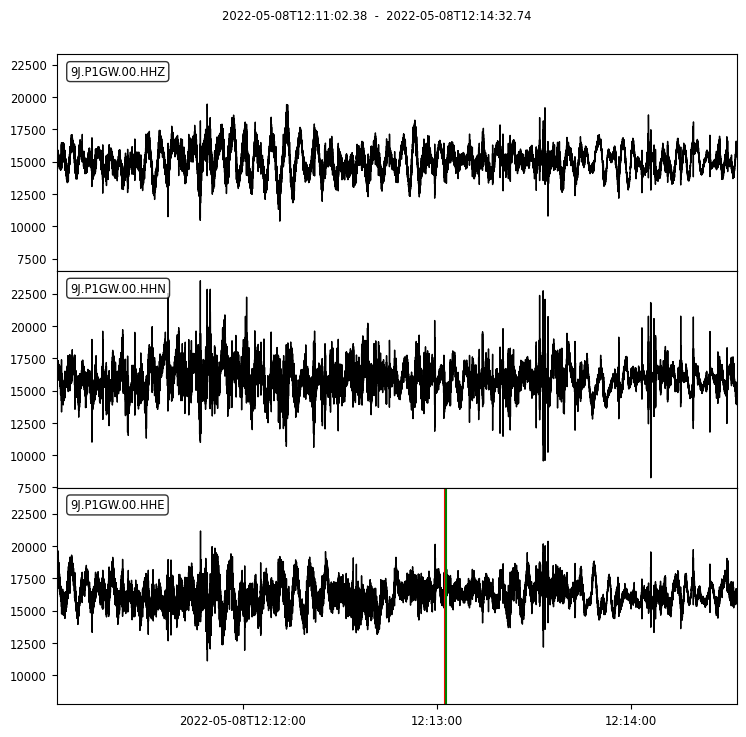

retrained model retrained_phasenet_ethz:


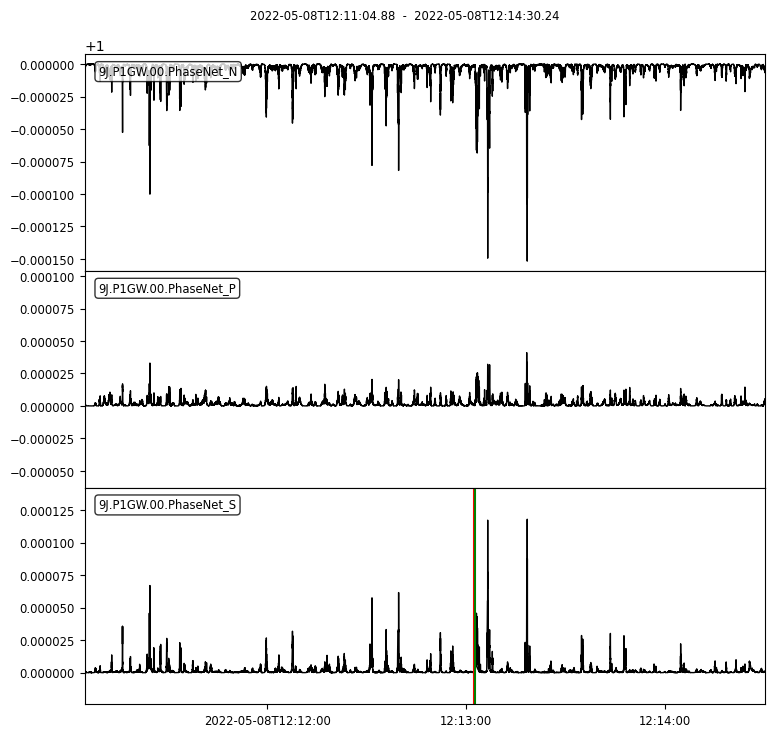

reference model:


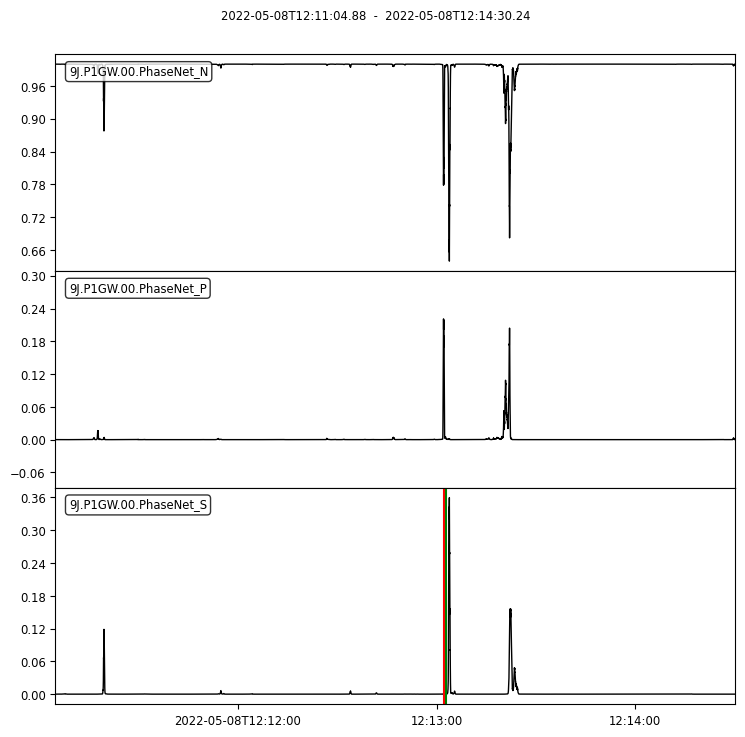

 P waves arrival time: 2022-04-24T09:48:25.720000Z
S waves arrival time: 2022-04-24T09:48:25.840000Z
Streams from: 9J B3FZ


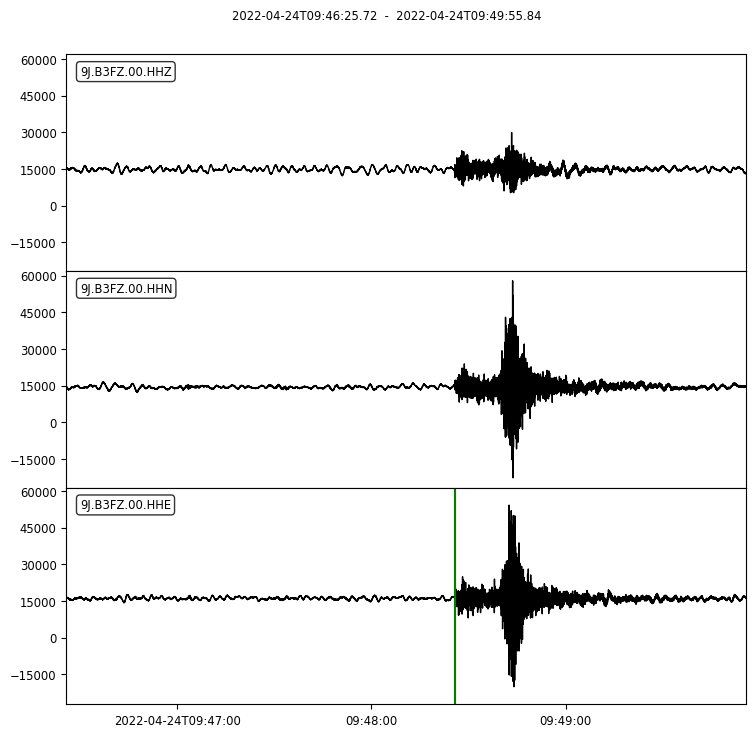

retrained model retrained_phasenet_ethz:


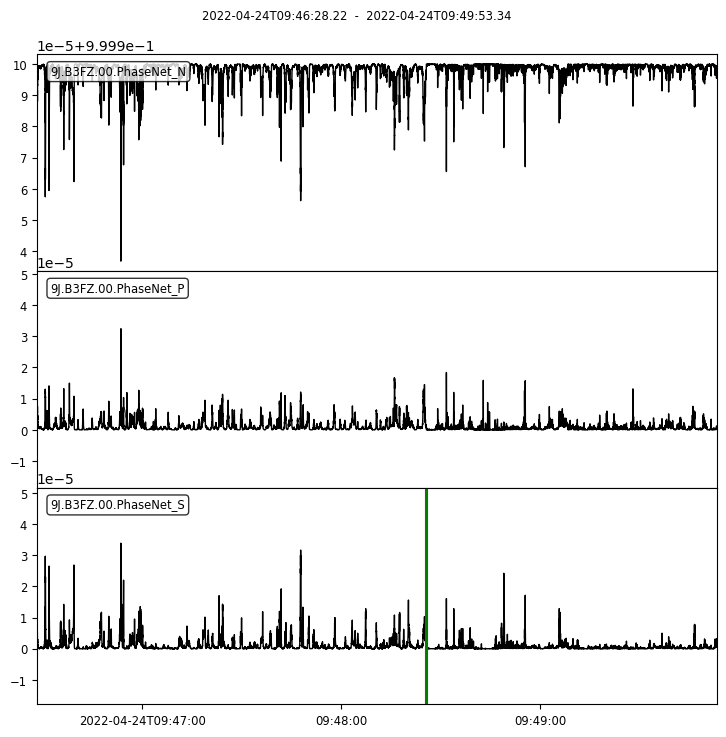

reference model:


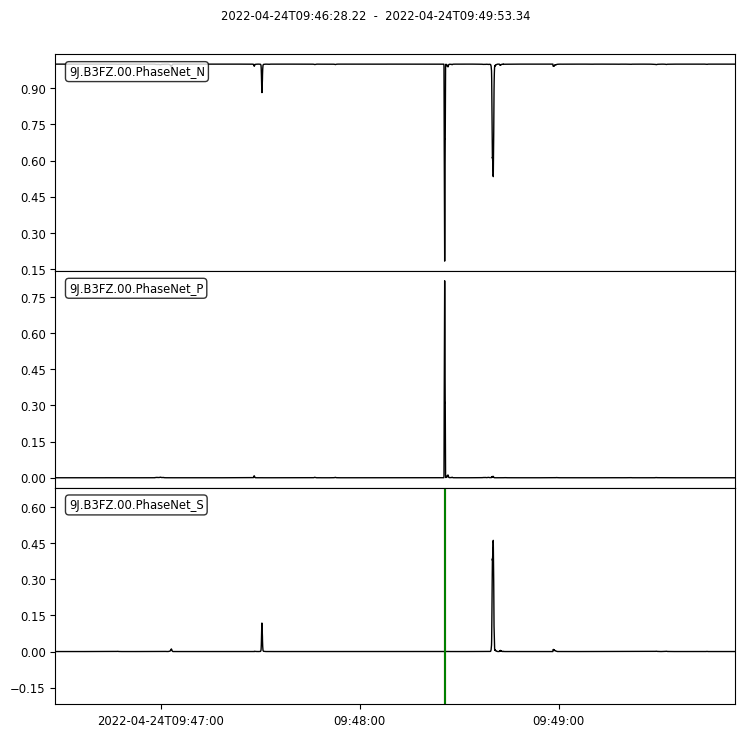

 P waves arrival time: 2022-04-21T04:15:10.000000Z
S waves arrival time: 2022-04-21T04:15:10.460000Z
Streams from: 9J G2EB


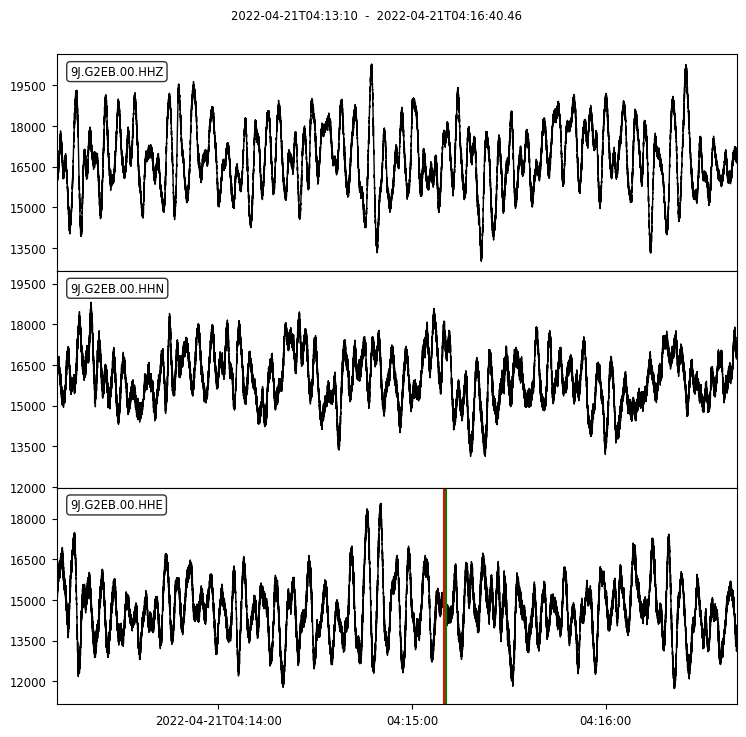

retrained model retrained_phasenet_ethz:


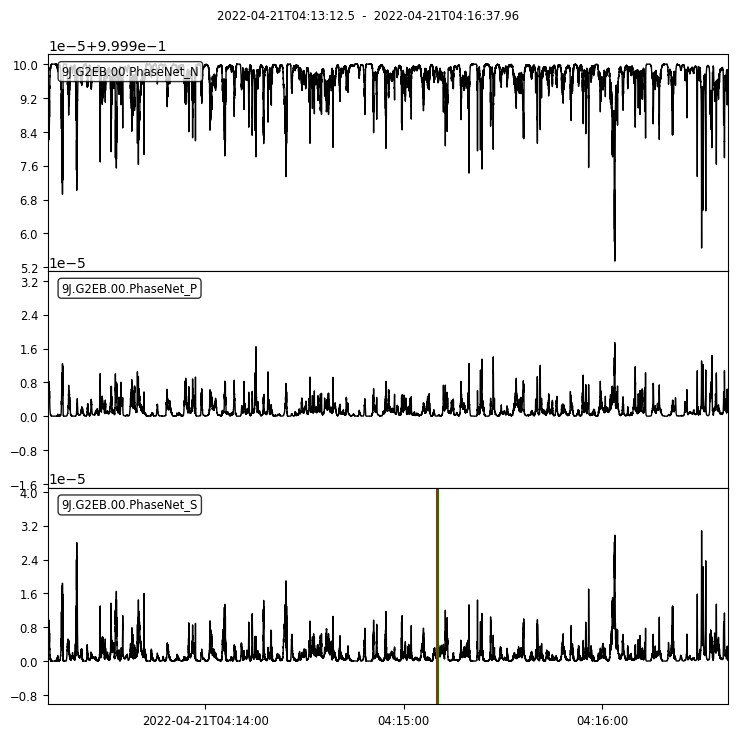

reference model:


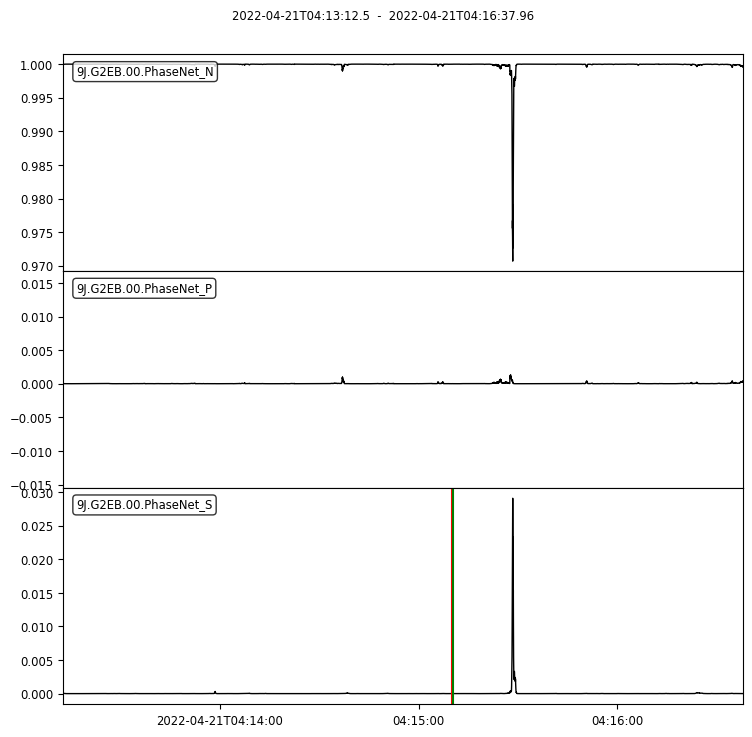

 P waves arrival time: 2022-05-08T12:13:02.060000Z
S waves arrival time: 2022-05-08T12:13:02.380000Z
Streams from: GB TARL


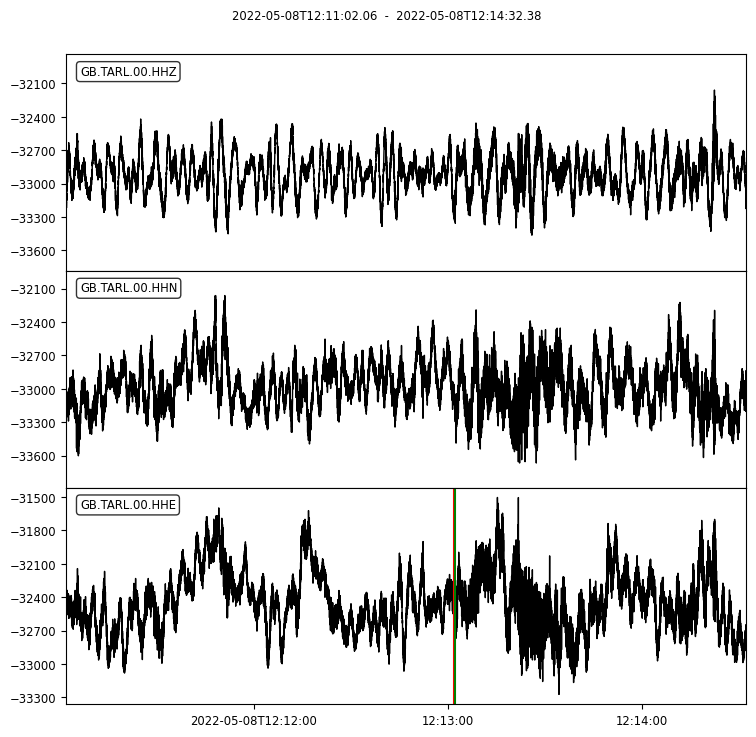

retrained model retrained_phasenet_ethz:


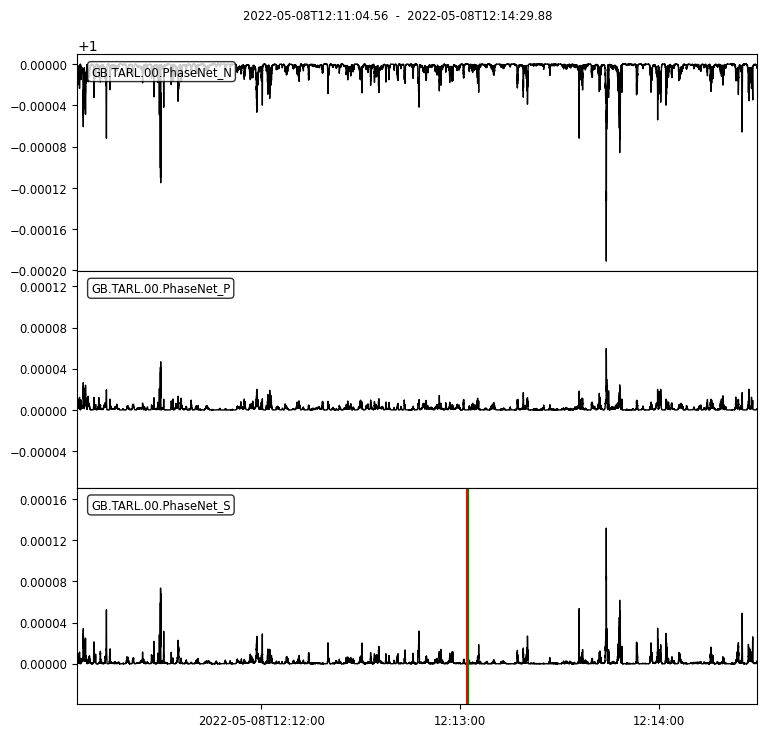

reference model:


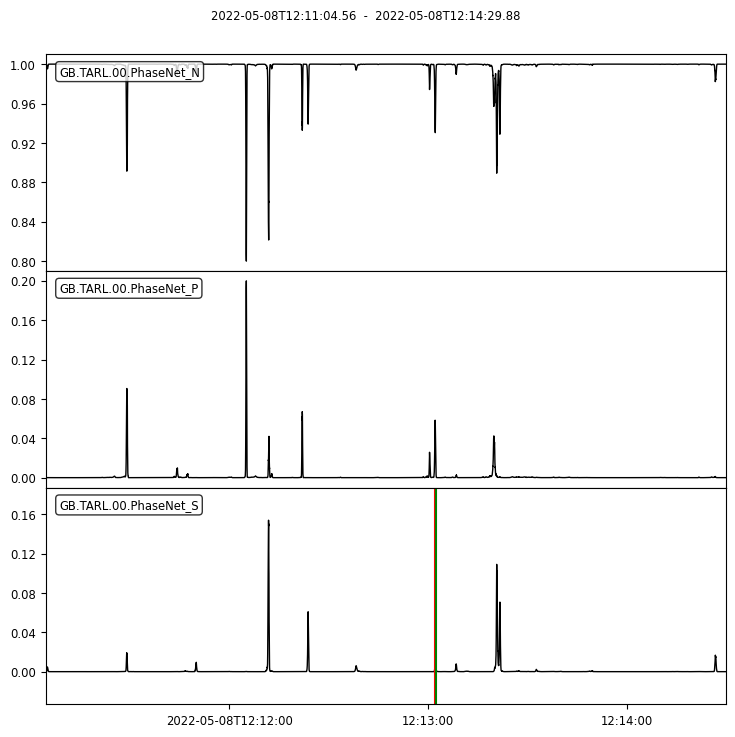




**********
Model: etrained_phasenet_stead
 P waves arrival time: 2022-05-08T12:13:01.400000Z
S waves arrival time: 2022-05-08T12:13:01.850000Z
Streams from: 9J G3GB


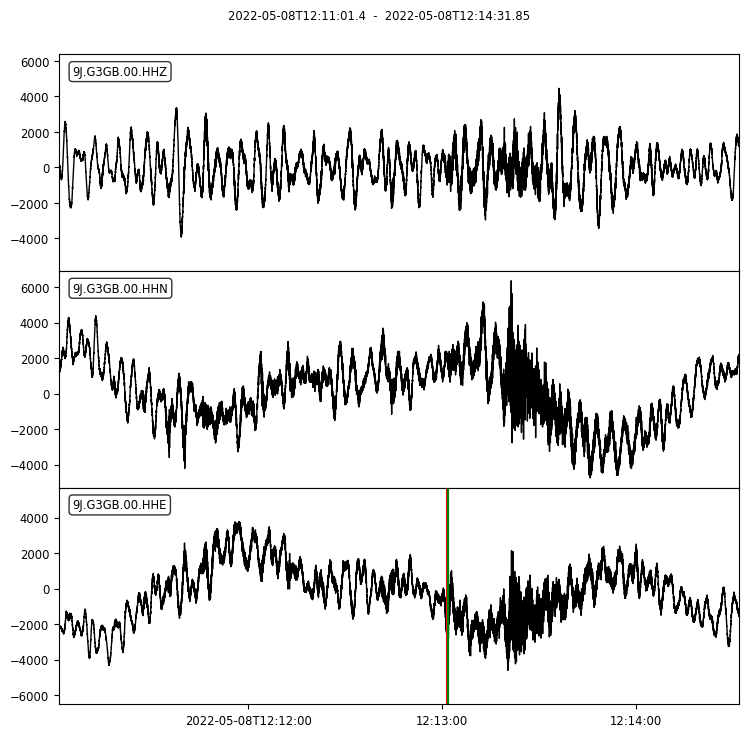

retrained model etrained_phasenet_stead:


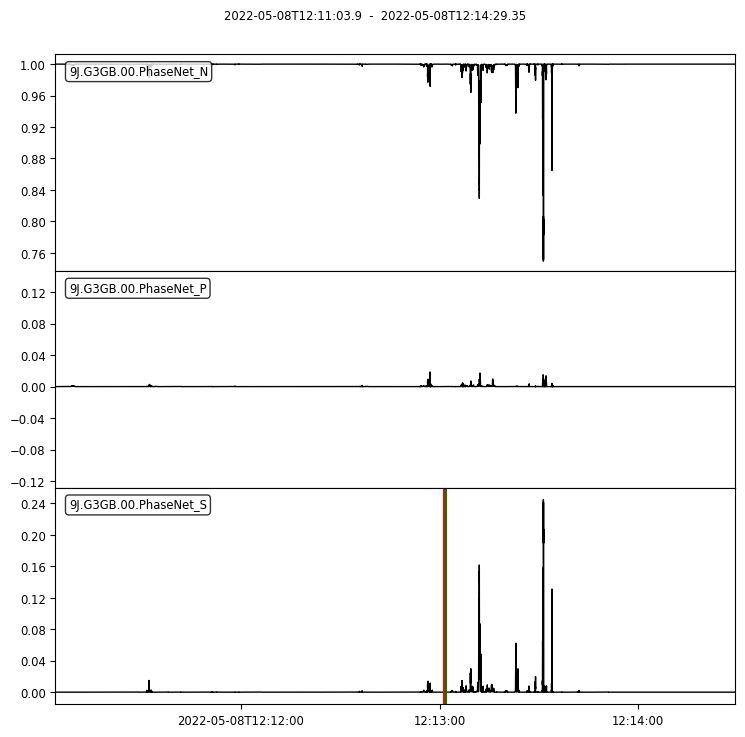

reference model:


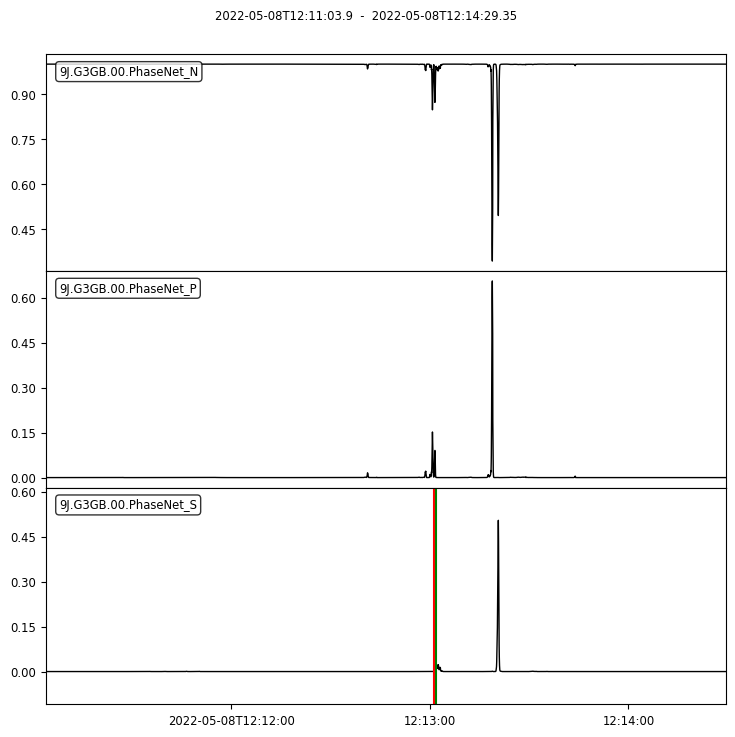

 P waves arrival time: 2022-05-08T12:12:59.610000Z
S waves arrival time: 2022-05-08T12:12:59.810000Z
Streams from: 9J P3MM


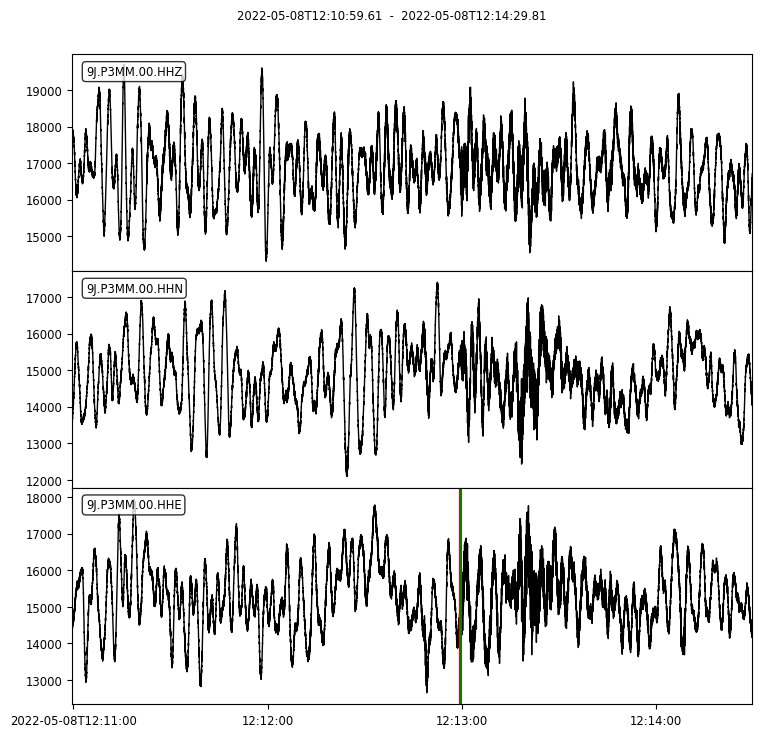

retrained model etrained_phasenet_stead:


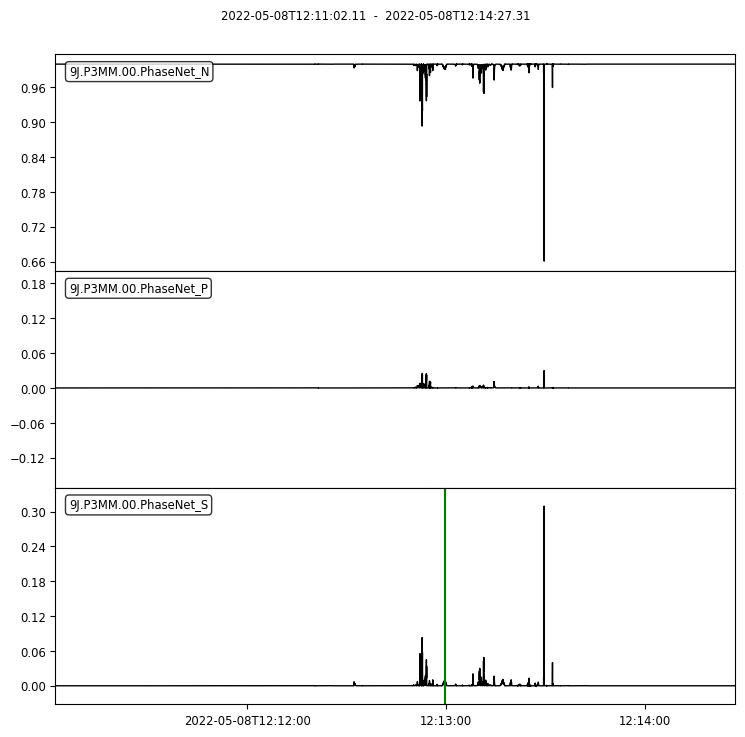

reference model:


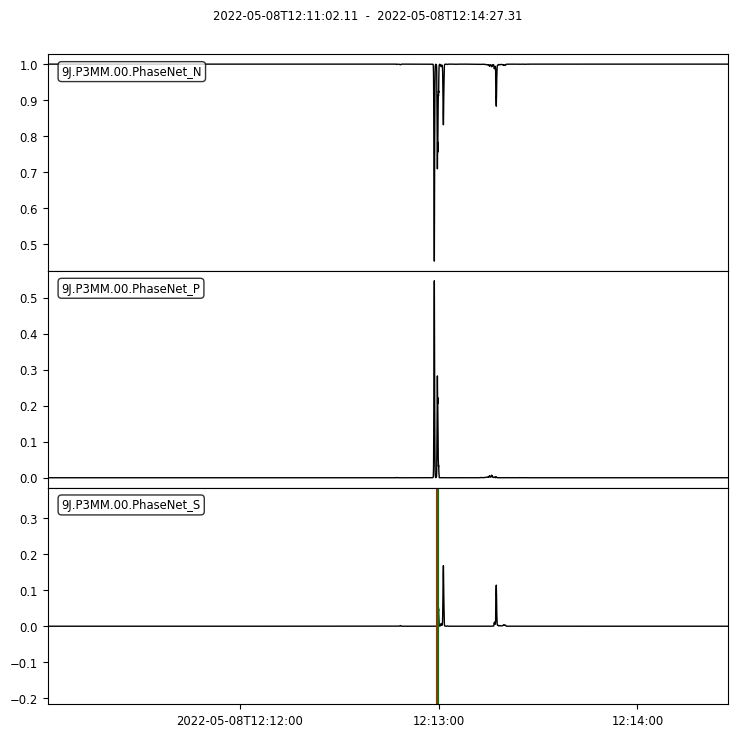

 P waves arrival time: 2022-05-08T12:13:02.380000Z
S waves arrival time: 2022-05-08T12:13:02.740000Z
Streams from: 9J P1GW


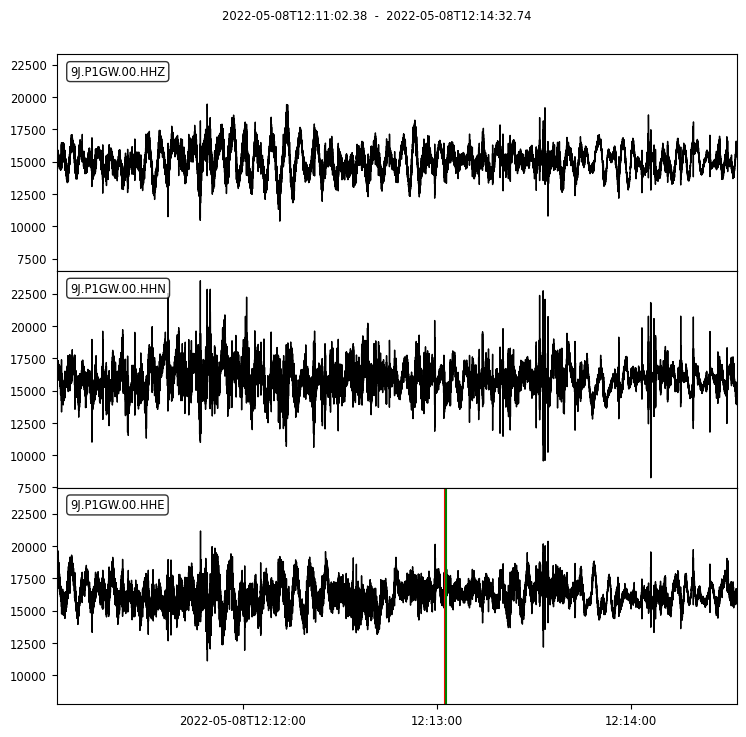

retrained model etrained_phasenet_stead:


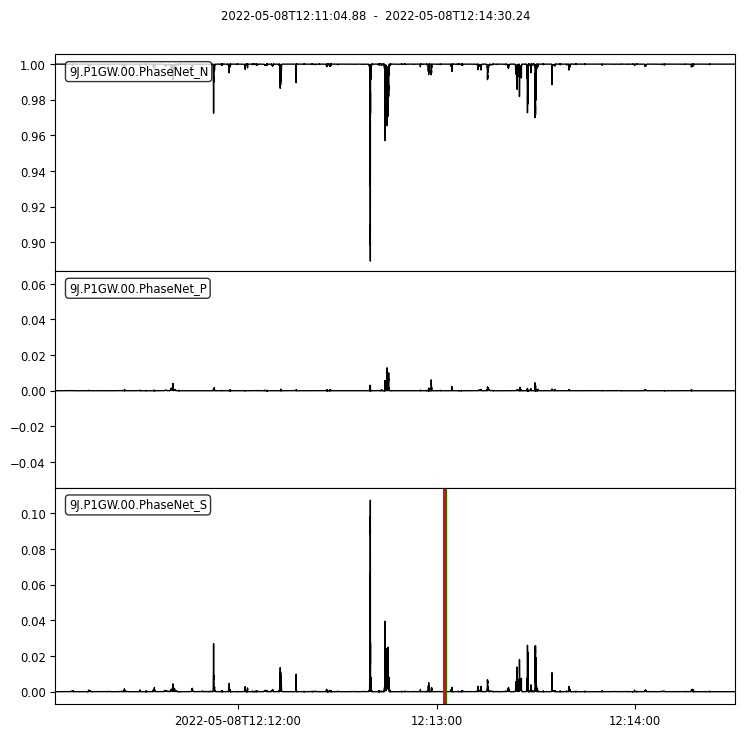

reference model:


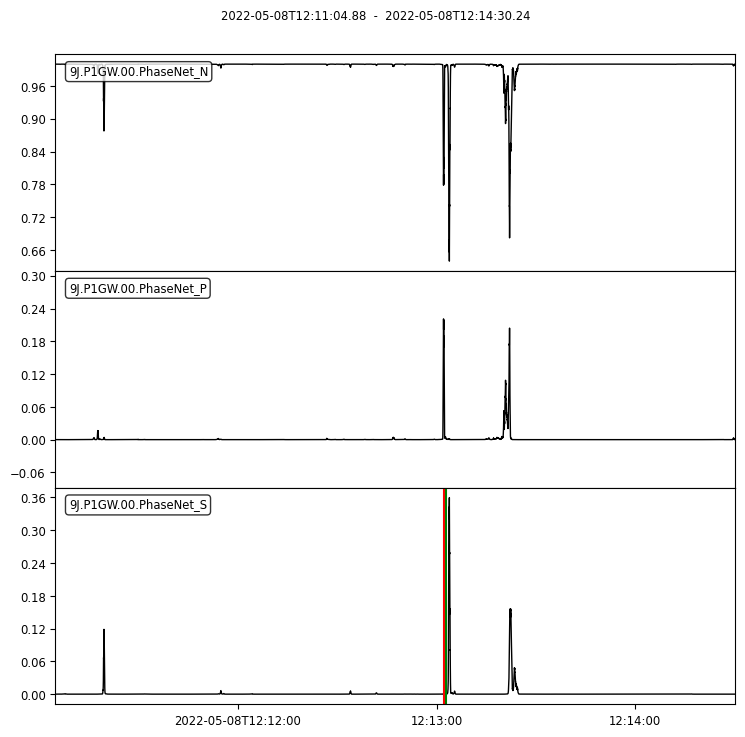

 P waves arrival time: 2022-04-24T09:48:25.720000Z
S waves arrival time: 2022-04-24T09:48:25.840000Z
Streams from: 9J B3FZ


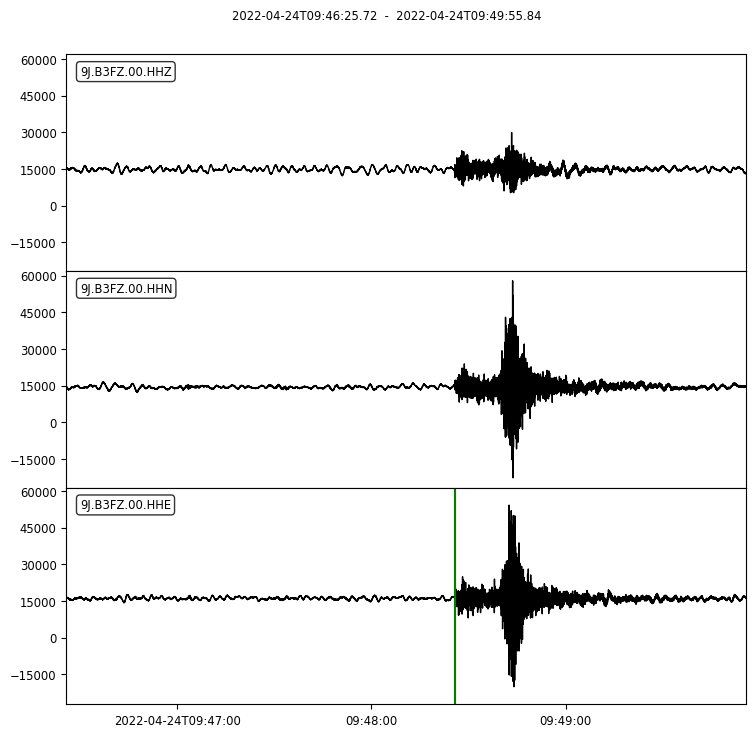

retrained model etrained_phasenet_stead:


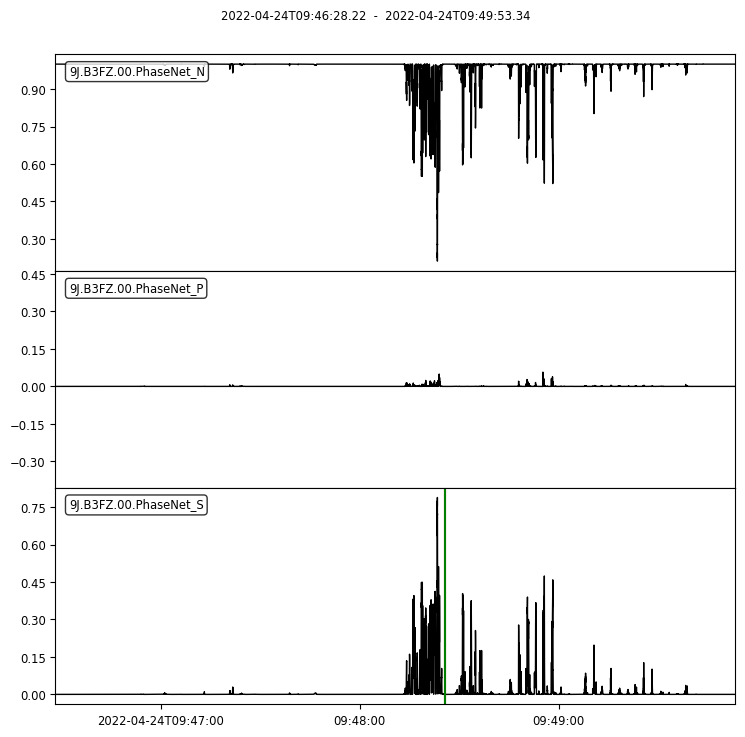

reference model:


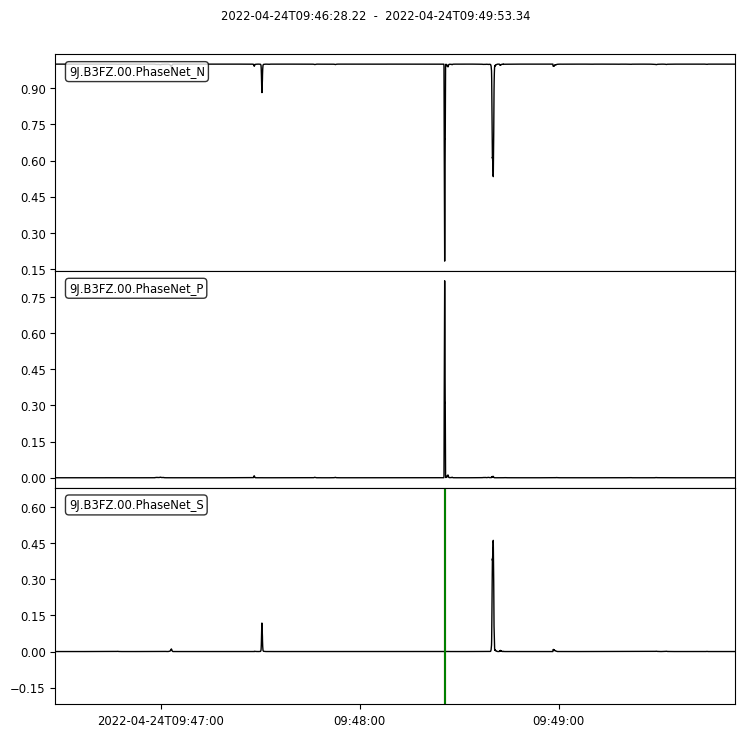

 P waves arrival time: 2022-04-21T04:15:10.000000Z
S waves arrival time: 2022-04-21T04:15:10.460000Z
Streams from: 9J G2EB


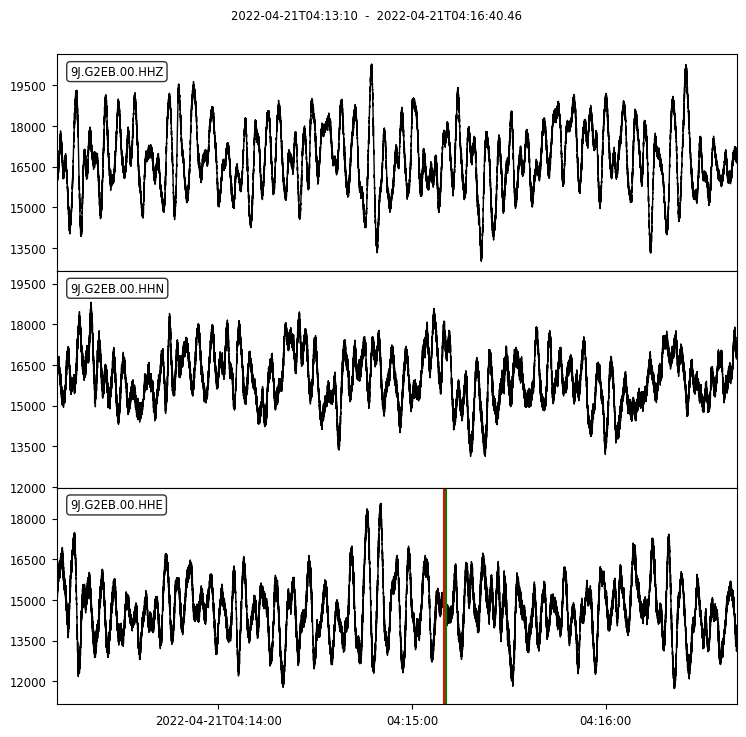

retrained model etrained_phasenet_stead:


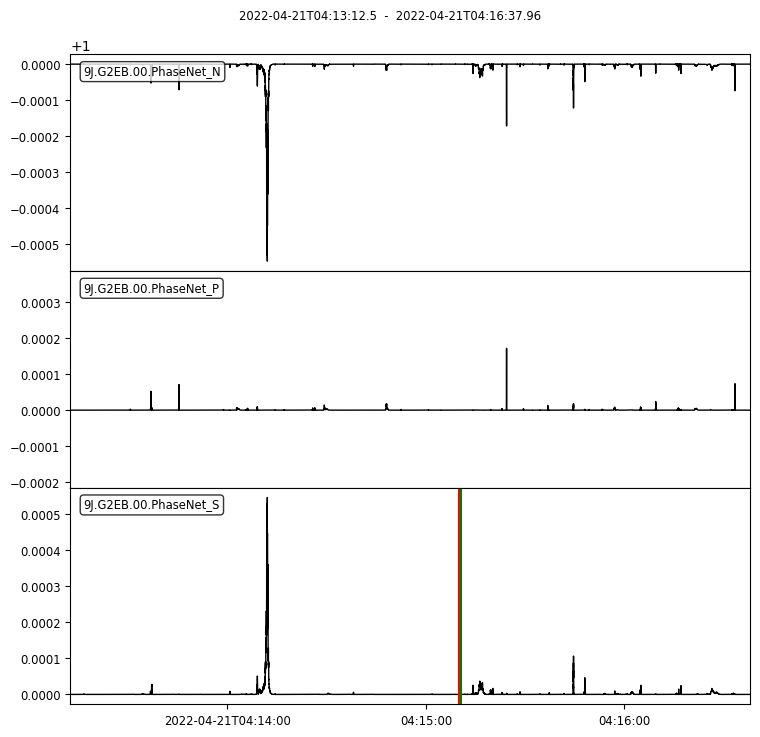

reference model:


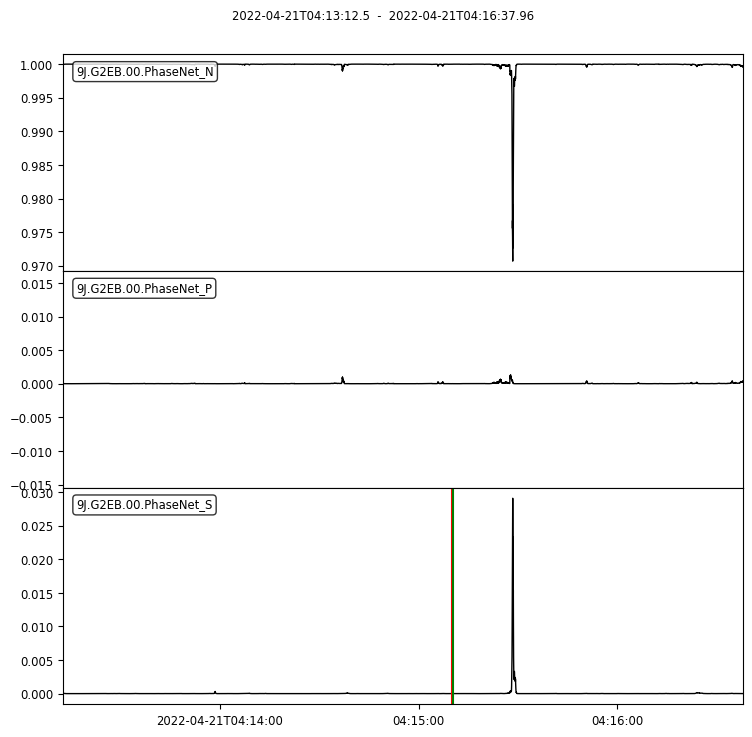

 P waves arrival time: 2022-05-08T12:13:02.060000Z
S waves arrival time: 2022-05-08T12:13:02.380000Z
Streams from: GB TARL


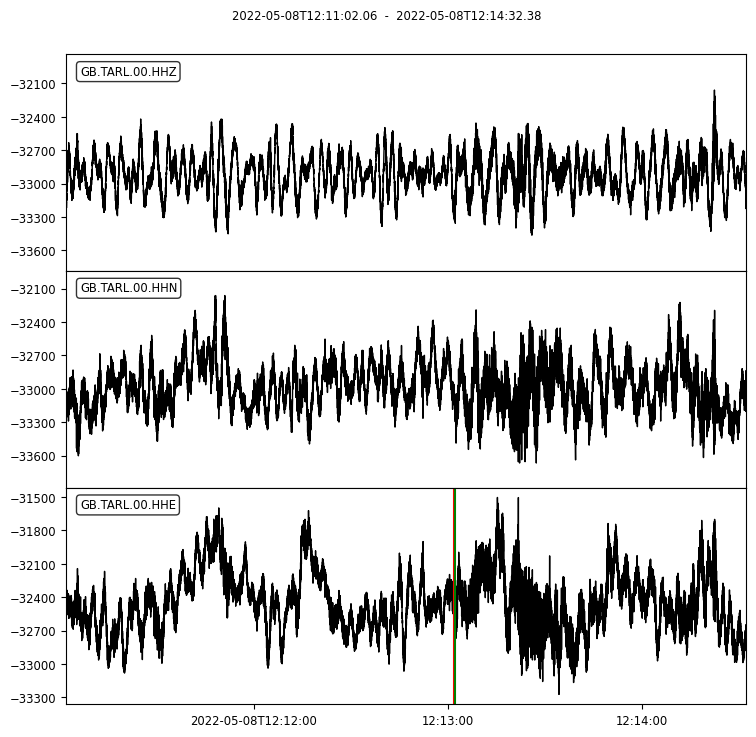

retrained model etrained_phasenet_stead:


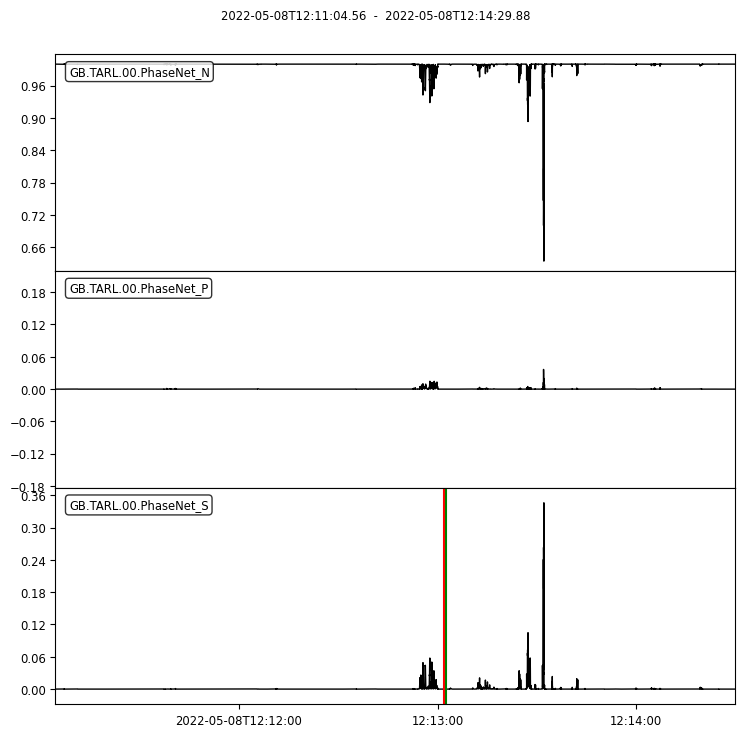

reference model:


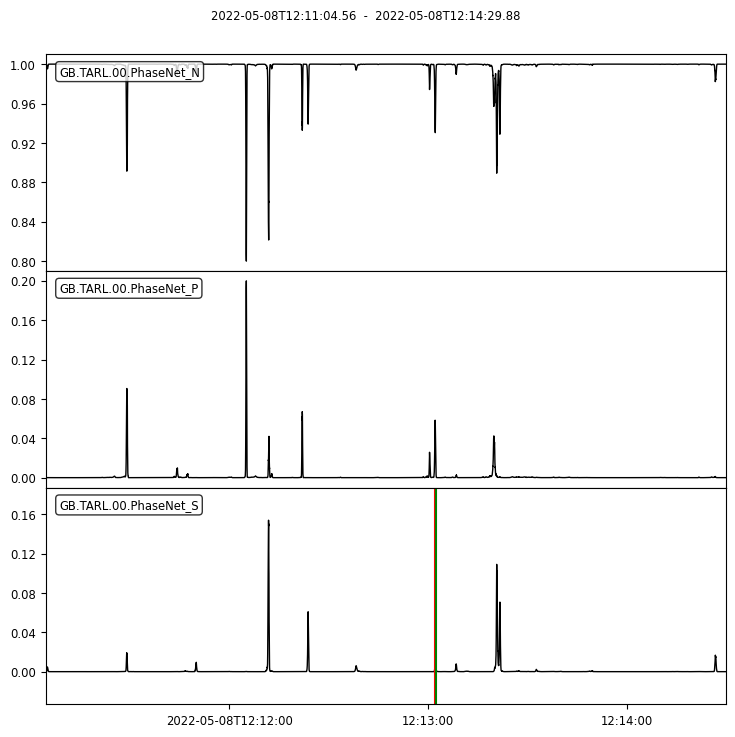

In [160]:
for model, model_name in [(retrained_phasenet_instance, "retrained_phasenet_instance"),
                          (retrained_phasenet_ethz, "retrained_phasenet_ethz"),
                          (retrained_phasenet_stead, "etrained_phasenet_stead")]:
    
    window_buffer = [120, 90]  # size, in seconds, of the window around the P & S waves arriving

    # gap between different models being displayed
    print("\n\n")
    print("*" * 10)
    print(f"Model: {model_name}")

    # loop over the arrivals in test dataset
    for location, p_arr_time in p_arrivals.items():
        network = location[0]
        station = location[1]
        s_arr_time = s_arrivals[(network, station)]
        print(f" P waves arrival time: {p_arr_time}\nS waves arrival time: {s_arr_time}")

        streams = functions.get_relevant_streams(start_time=(p_arr_time-window_buffer[0]),
                                       end_time=(s_arr_time+window_buffer[1]),
                                       network=network,
                                       station=station,)
        print(f"Streams from: {network} {station}")
        # plot the graphs
        fig = streams.plot(handle=True)
        for x in fig.axes:
            x.axvline(x = p_arr_time, color = 'red', label = 'P')
            x.axvline(x = s_arr_time, color = 'green', label = 'S')
        plt.show()
        print(f"retrained model {model_name}:")
        annotations = model.annotate(streams)
        fig2 = annotations.plot(handle=True)
        for x in fig2.axes:
            x.axvline(x = p_arr_time, color = 'red', label = 'P')
            x.axvline(x = s_arr_time, color = 'green', label = 'S')
        plt.show()
        print("reference model:")
        annotations = ref_model.annotate(streams)
        fig3 = annotations.plot(handle=True)
        for x in fig3.axes:
            x.axvline(x = p_arr_time, color = 'red', label = 'P')
            x.axvline(x = s_arr_time, color = 'green', label = 'S')
        plt.show()